# Исследование влияния различных факторов на продажи игр

Цель данного проекта - спланировать кампанию на 2017 год на основе исторических данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

## Шаг 1. Просмотр файла с данными и изучение общей информации

Импортирую библиотеки, нужные для работы, после чего открываю файл и изучаю общую информацию о нём. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Также нужно построить общую гистограмму для всех столбцов таблицы. 

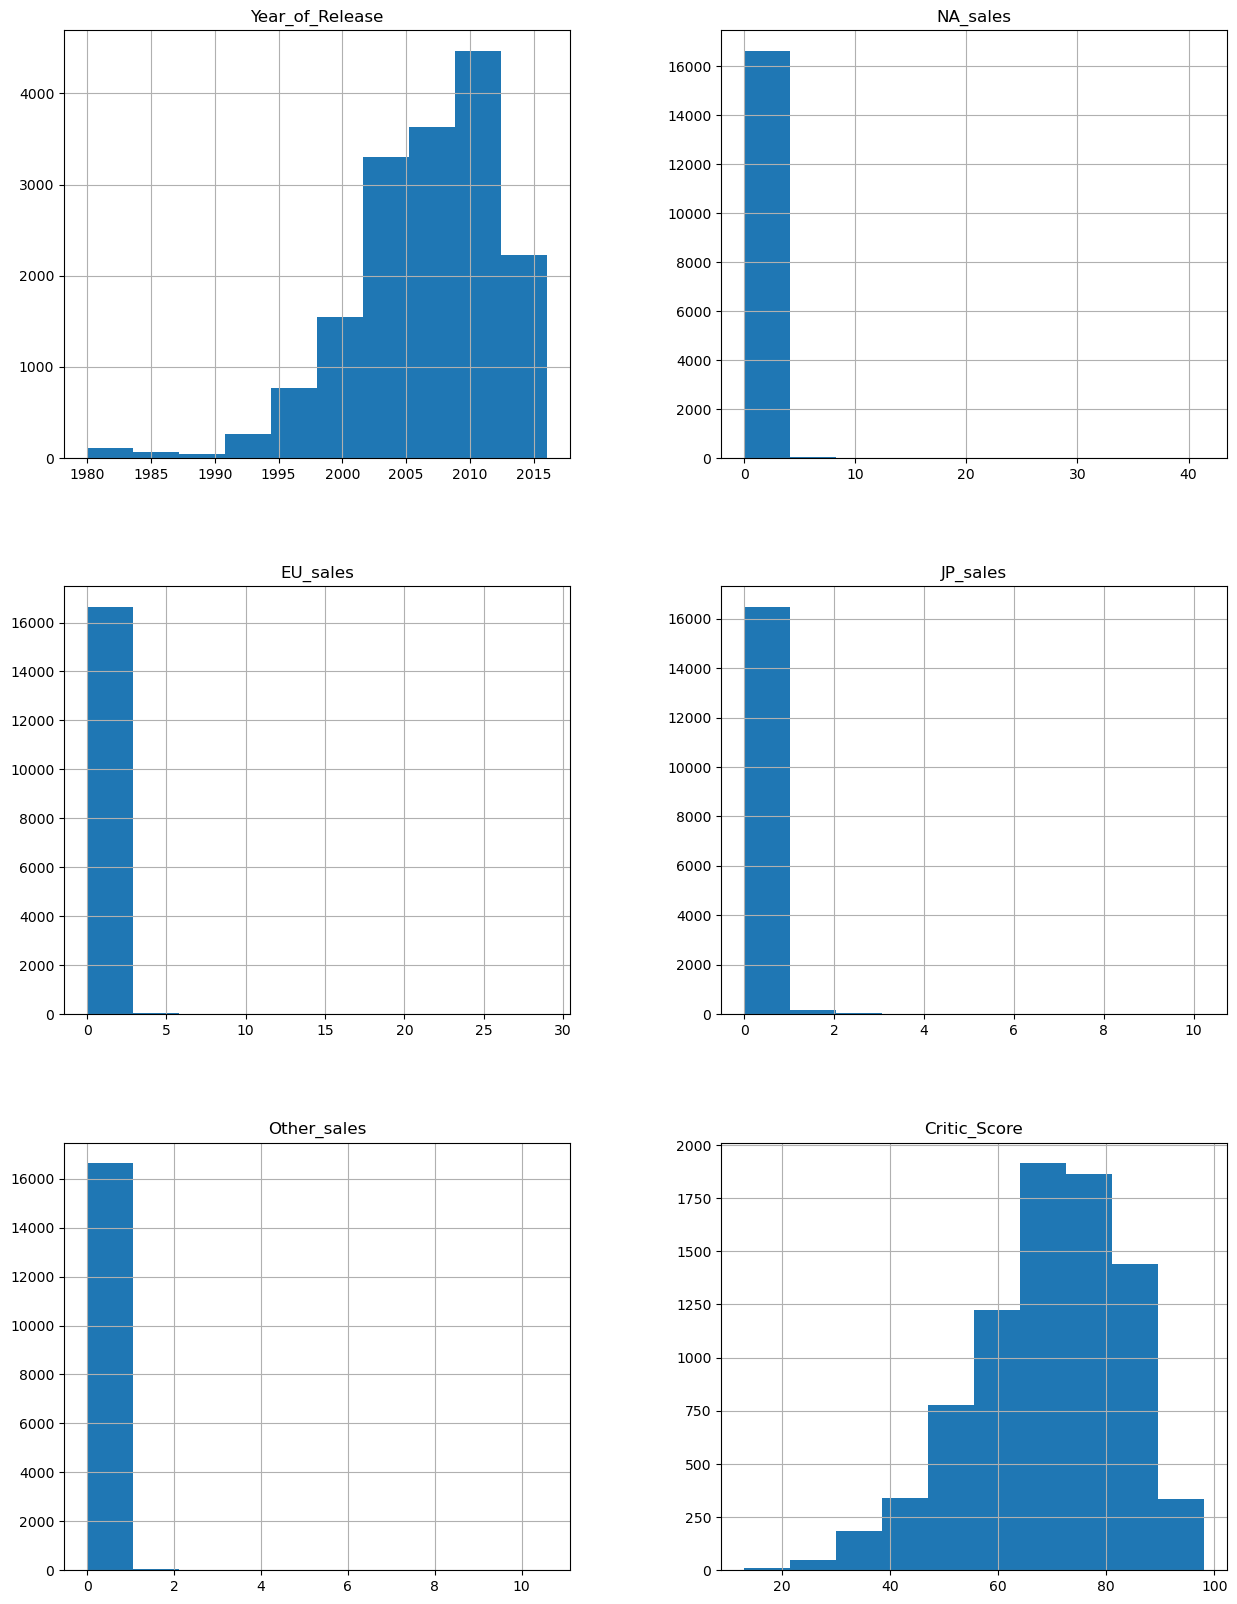

In [4]:
data.hist(figsize=(15, 20));

В предоставленных данных имеется небольшое количество пропущенных значений, также необходимо изучить их подробнее и провести предобработку. 

## Шаг 2. Подготовка данных

###  Изменение названий столбцов

Для дальнейшей работы с данными нужно провести предобработку. В первую очередь нужно привести все значения в столбцах к единому регистру для удобства работы. 

In [5]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Теперь, когда все столбцы приведены к нижнему регистру, нужно изменить типы данных там, где это необходимо. 

### Преобразование данных в нужные типы

In [8]:
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

В столбце year_of_release должен быть тип данных int, поскольку год - обязательно число целое, а не дробное. Чтобы изменить тип данных в этом столбце, необходимо предварительно удалить пропуски в этом столбце - их немного и это не повлияет на репрезентативность данных.  В столбце user_score должен быть тип данных float, а не object. 

In [9]:
# проверка количества строк до удаления пропусков
data.shape[0]

16715

In [10]:
data = data.dropna(subset = 'year_of_release')

In [11]:
# проверка количества строк после удаления пропусков
data.shape[0]

16446

In [12]:
data['year_of_release'] = data['year_of_release'].astype('int32')

In [13]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Проверим, все ли изменения вступили в силу:

In [14]:
data.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

### Обработка пропусков

Для дальнейшего исследования данных нужно удалить или заполнить пропуски там, где это возможно. Для начала изучим, в каких столбцах встречаются пропуски.

In [15]:
data.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64

В столбцах name и genre встречается только два пропуска, поэтому их можно просто удалить. 

In [16]:
data = data.dropna(subset = 'name')
data = data.dropna(subset = 'genre')

Изучим данные в столбце user_score, просмотрев уникальные значения по каждому столбцу:

В столбцах critic_score, user_score и rating встречается весьма большое количество пропусков: больше трети всего датафрейма. Удалять такое количество данных нельзя, но в дальнейшем по этим данным необходимо будет строить гипотезы и исследовать их, поэтому заполнять их медианой или средним арифметическим недопустимо. Оставим эти пропуски, заполнив строки значением NaN

In [17]:
data['critic_score'] = data['critic_score'].fillna('NaN')
data['user_score'] = data['user_score'].fillna('NaN')
data['rating'] = data['rating'].fillna('NaN')

In [18]:
data['user_score'].unique()

array([8.0, 'NaN', 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9.0, 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7.0, 7.3, 4.3, 7.6, 5.7, 5.0, 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4.0, 4.9, 4.5, 9.3, 6.2, 4.2, 6.0, 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3.0, 2.7, 2.2, 2.0, 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0.0,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1.0, 9.7], dtype=object)

In [19]:
data.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score        object
user_score          object
rating              object
dtype: object

После заполнения пропусков нужно исправить типы данных с оценками от критиков и игроков на float. 

In [20]:
data['critic_score'] = data['critic_score'].astype('float')    
data['user_score'] = data['user_score'].astype('float')    

Природа пропусков в столбцах с оценками от критиков и игроков, возможно, объясняется небольшой популярностью некоторых игр: они просто не получили достаточно оценок для присвоения рейтинга. 
В случае с ESRB рейтингом можно предполагать, что не все игры подавались на присвоение этого рейтинга. 

### Проверка на наличие дубликатов

In [21]:
data.duplicated().sum()

0

Дубликатов в датафрейме не обнаружено.

### Расчёт суммарных продаж во всех регионах

Добавим отдельный столбец, хранящий данные о суммарных продажах по всем регионам. 

In [22]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [23]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Промежуточный вывод

В ходе предобработки были приведены к нижнему регистру названия столбцов, изменены типы данных там, где это было необходимо, и устранены пропуски. В нескольких столбцах пропусков было немного, поэтому строки с пропусками просто были удалены. В столбцах с данными об оценках от критиков и пользователях и возрастном рейтинге предположить логичную замену не удалось, поэтому пропуски были заполнены заглушкой "undefined".

## Шаг 3. Исследовательский анализ данных

### Изучение количества игр, выпускавшихся в разные годы

Изучим количество игр, которые выпускались в разные годы. 

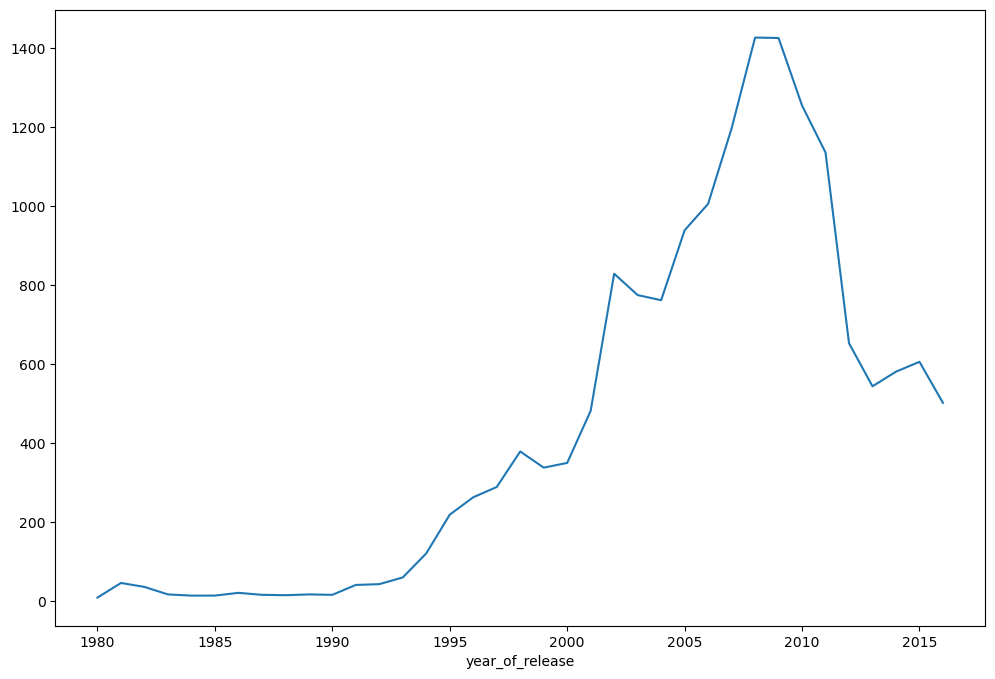

In [24]:
data.groupby('year_of_release')['year_of_release'].count().plot(figsize = (12, 8));

Количество выпускаемых игр с годами значительно возросло. Больше всего игр было выпущено с 2006 по 2011 год. 

### Изучение изменений продаж по платформам

Изучим изменение продаж в зависимости от платформы. Для начала посмотрим, какие суммарные продажи у разных платформ. 

In [25]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending=False)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: all_sales, dtype: float64

Наибольшие суммарные продажи здесь имеют PS2(1233), PS3(931), X360(961), DS(802) и Wii(891). 
Построим распределение по годам для платформ.

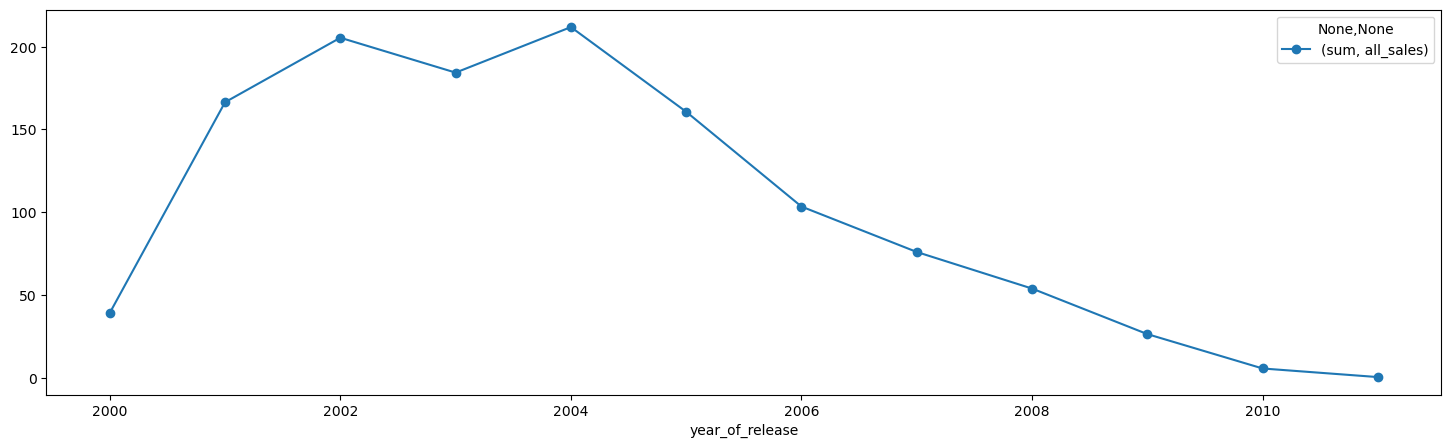

In [26]:
data[data['platform'] == 'PS2'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам PS2');

Продажи на платформе PS2 росли до 2004 года, но потом пошли на спад и к 2010 году практически прекратились.

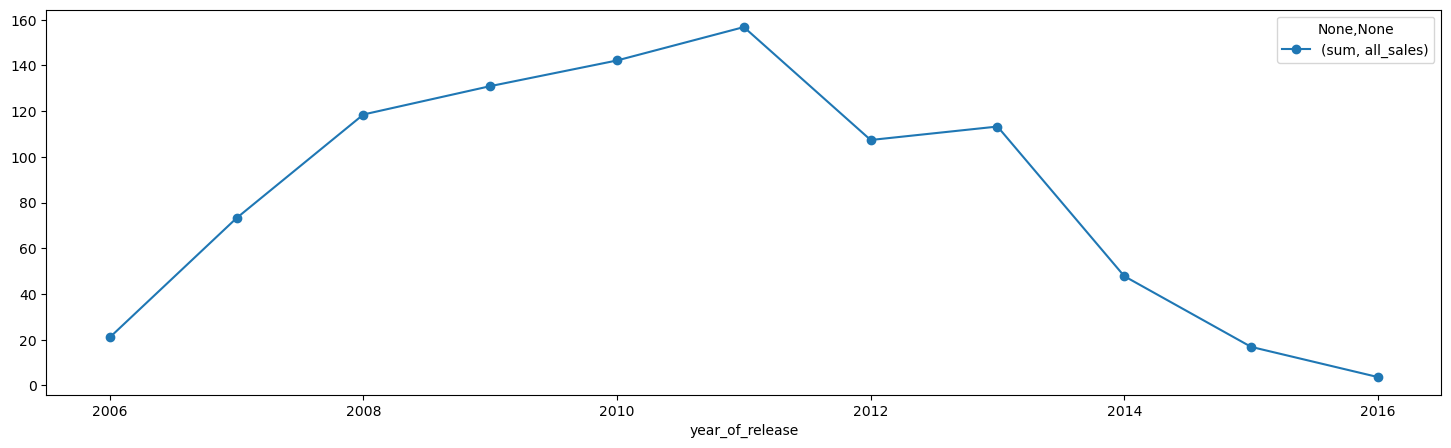

In [27]:
data[data['platform'] == 'PS3'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам PS3');

Продажи PS3 начались в 2006 год, потом начали расти, но с 2013 года значительно идут на спад.

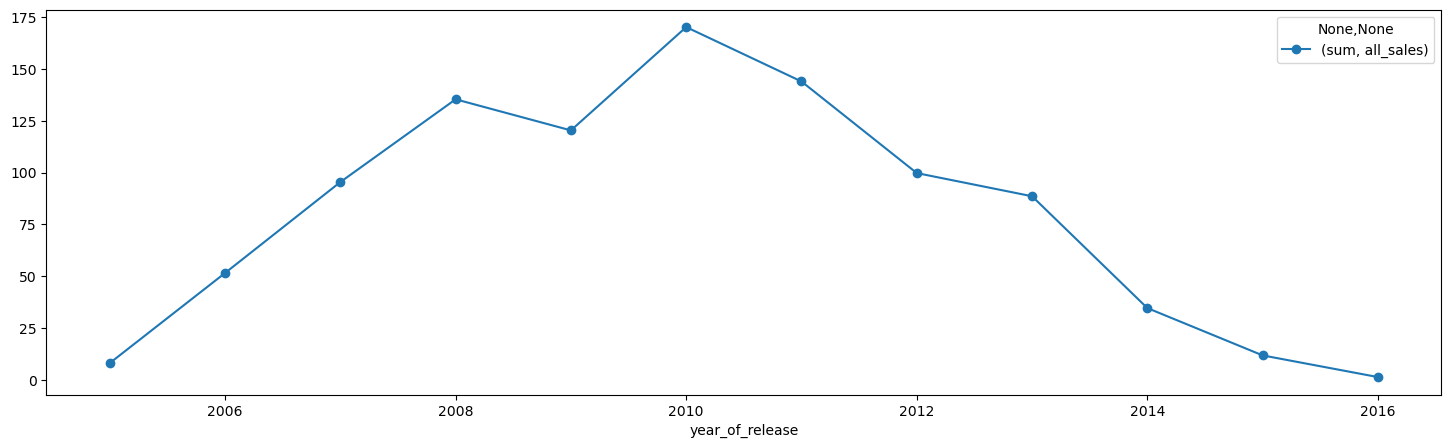

In [28]:
data[data['platform'] == 'X360'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам X360');

Для платформы Х360 продажи до 2010 года росли, но после значительно снизились. 

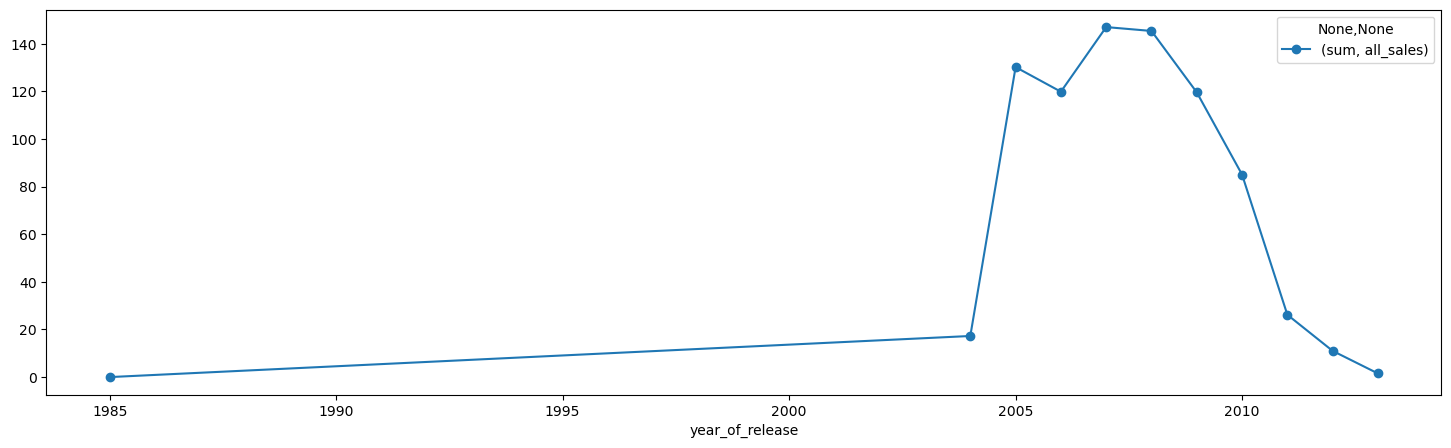

In [29]:
data[data['platform'] == 'DS'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам DS');

Платформа DS начала резкий рост в 2004 году, но к настоящему времени значительно снизила продажи. 

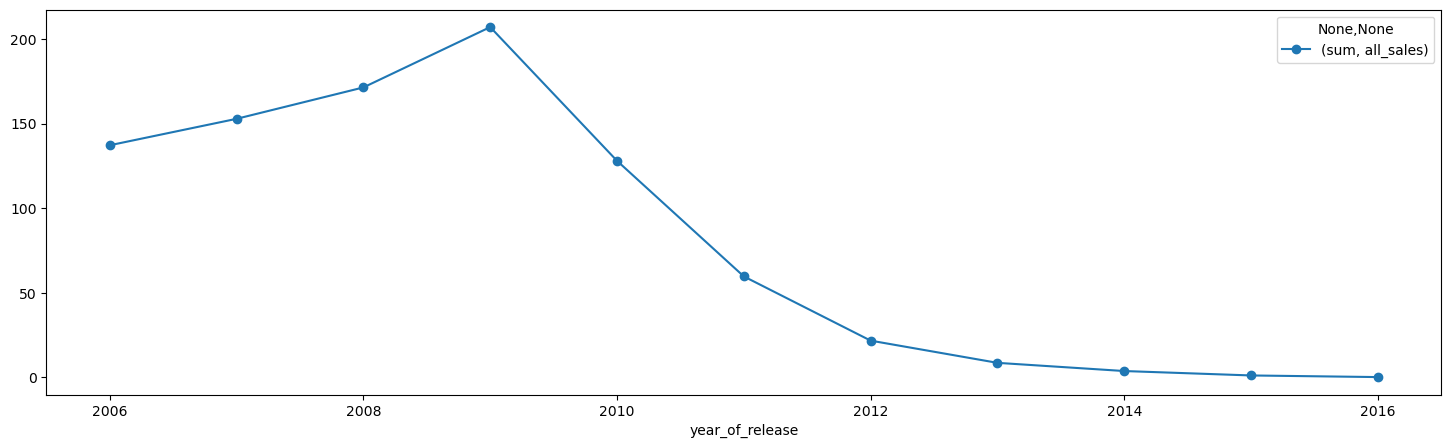

In [30]:
data[data['platform'] == 'Wii'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам Wii');

Wii росла до 2009 года, после пошла на сильный спад и с 2014 года имеет стабильно низкие продажи.

#### Создание среза актуальных данных

В дальнейшем исследовании не потребуется использовать весь датафрейм, поскольку цель исследования - построить прогноз на 2017 год. Для полноценной выборки возьмём данные с 2010 года. 

In [31]:
data_relevant = data.loc[data['year_of_release'] >= 2010]
data_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 14 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5277 non-null   object 
 1   platform         5277 non-null   object 
 2   year_of_release  5277 non-null   int32  
 3   genre            5277 non-null   object 
 4   na_sales         5277 non-null   float64
 5   eu_sales         5277 non-null   float64
 6   jp_sales         5277 non-null   float64
 7   other_sales      5277 non-null   float64
 8   critic_score     2312 non-null   float64
 9   user_score       2499 non-null   float64
 10  rating           5277 non-null   object 
 11  all_sales        5277 non-null   float64
dtypes: float64(7), int32(1), object(4)
memory usage: 515.3+ KB


Был создан датафрейм на 5277 строк, хранящий в себе актуальные данные с 2010 года. Для дальнейшего исследования будет использоваться именно он. 

### Изучение лидирующих по продажам платформ и поиск потенциально прибыльных платформ

Изучим, какие платформы лидируют в релевантной выборке. 

In [32]:
data_relevant.groupby('platform')['all_sales'].sum().sort_values(ascending=False)

platform
PS3     587.74
X360    550.41
PS4     314.14
3DS     257.81
Wii     222.97
XOne    159.32
DS      123.75
PC      121.96
WiiU     82.19
PSP      64.05
PSV      53.81
PS2       6.09
Name: all_sales, dtype: float64

В последние годы самой популярной игровой платформой была PS3(587). На втором месте X360(550). Третье место у PS4(314). Четвёртое у 3DS(257), и пятое у Wii(222).
Выделим отдельно данные о продажах для пяти наиболее популярных платформ и построим графики по годам. 

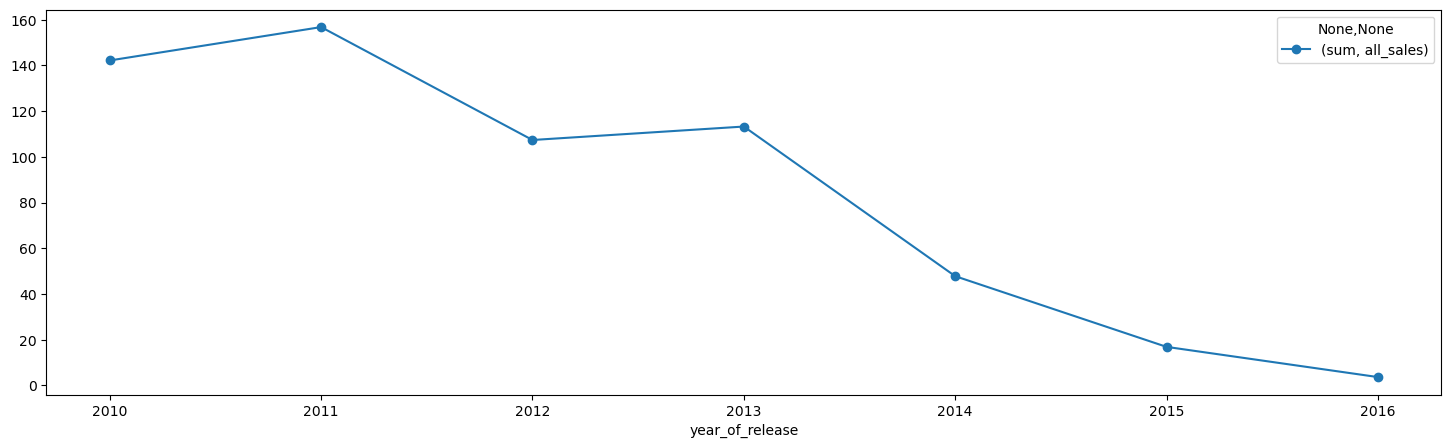

In [33]:
data_relevant[data_relevant['platform'] == 'PS3'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам PS3');

На гистограмме видно, что количество продаж PS3 к 2016 году неуклонно снижается.

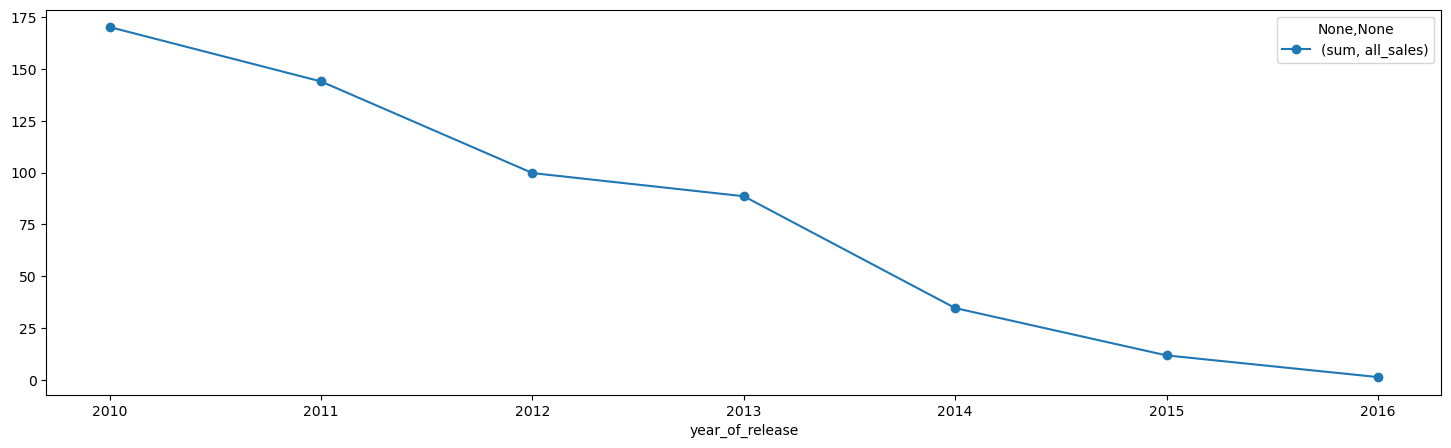

In [34]:
data_relevant[data_relevant['platform'] == 'X360'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам X360');

Продажи X360 также идут на спад. 

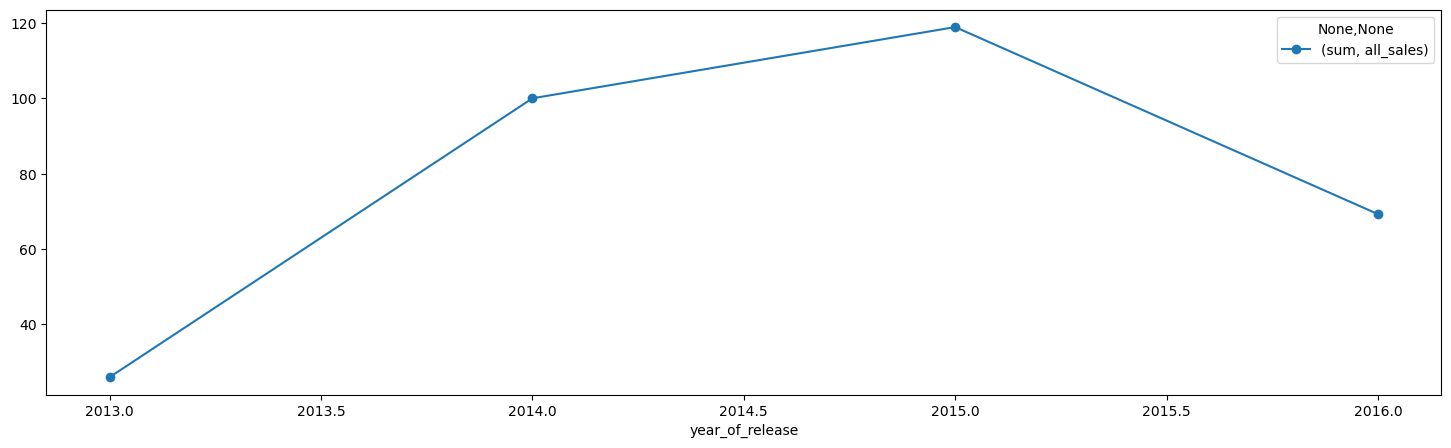

In [35]:
data_relevant[data_relevant['platform'] == 'PS4'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам PS4');

Продажи PS4 растут: к 2016 году видно некоторое снижение, но за 2016 год данные не полные, поэтому эту платформу всё же можно назвать перспективной. 

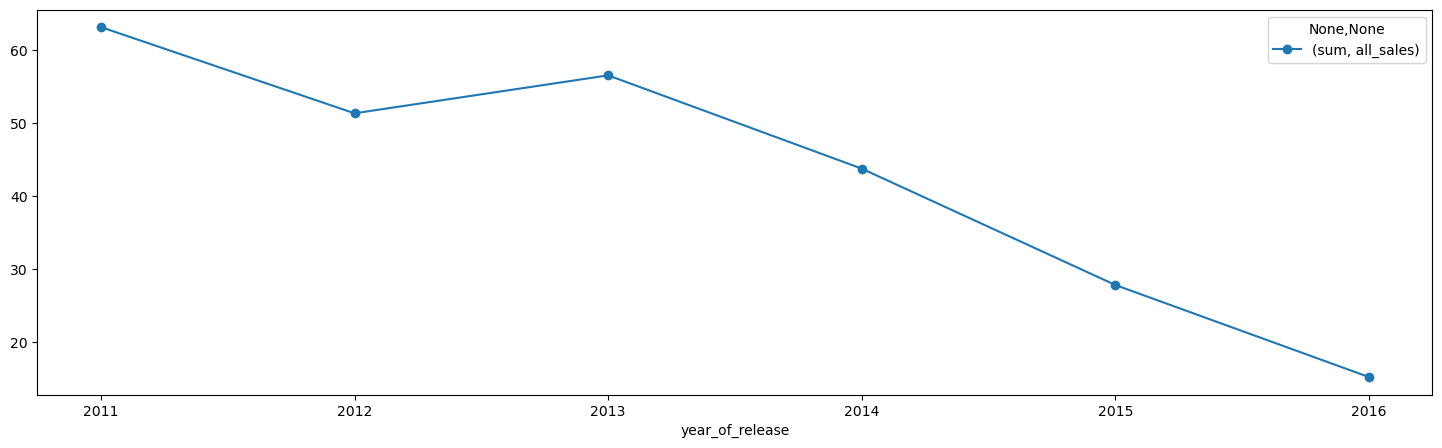

In [36]:
data_relevant[data_relevant['platform'] == '3DS'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам 3DS');

У платформы 3DS устойчивый спад продолжается с 2013 года, но уровень продаж достаточно высок: платформу можно считать перспективной. 

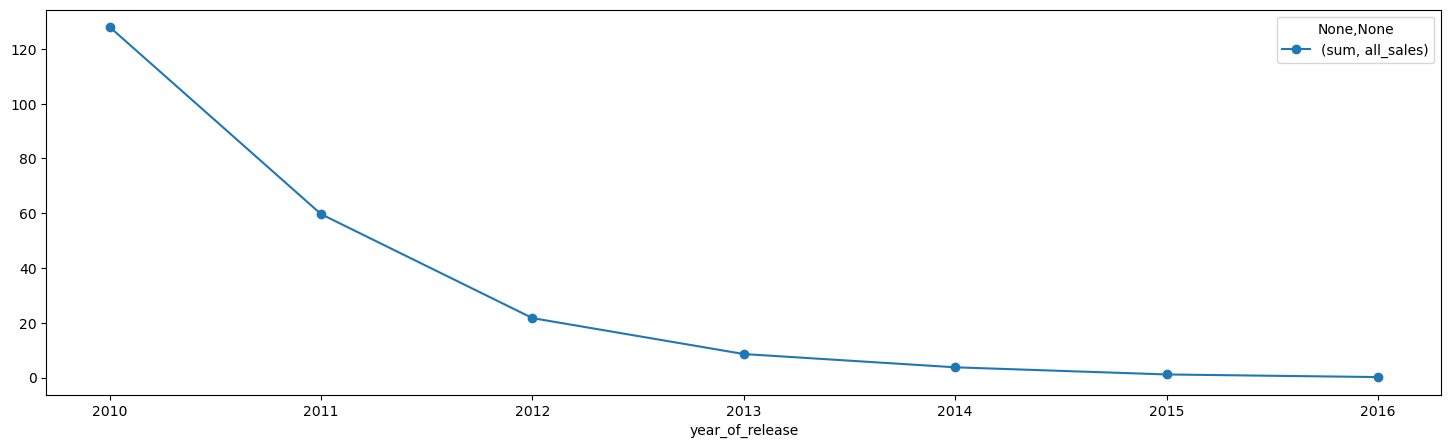

In [37]:
data_relevant[data_relevant['platform'] == 'Wii'].pivot_table(index=['year_of_release'], values='all_sales', aggfunc=['sum']).plot(style='o-', figsize = (18, 5), label='Распределение по годам Wii');

Платформа Wii идёт на спад с 2010 года и с 2013 года имеет стабильно низкие продажи. 

### Построение боксплотов по глобальным продажам игр в разбивке по платформам

Рассмотрим глобальные продажи игр по платформам через боксплоты. 

<AxesSubplot:>

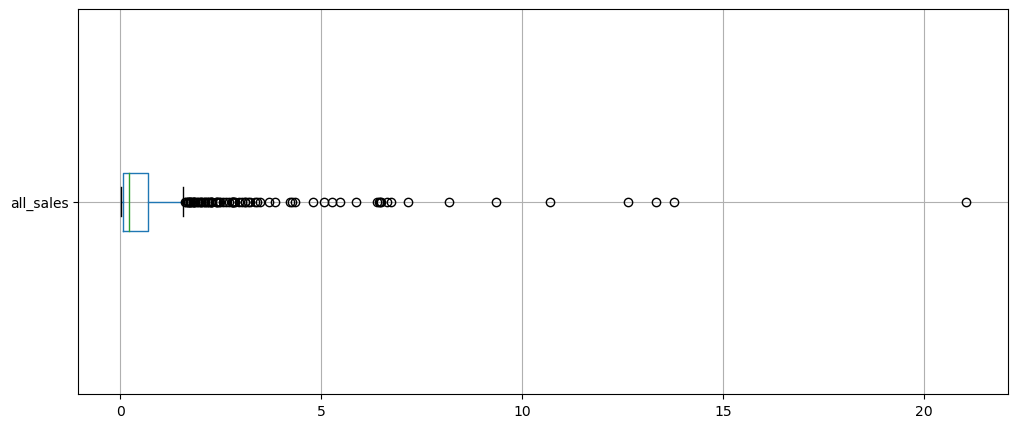

In [95]:
data_relevant[data_relevant['platform'] == 'PS3'].boxplot(column='all_sales', vert=False, figsize=(12,5))

(0.0, 3.0)

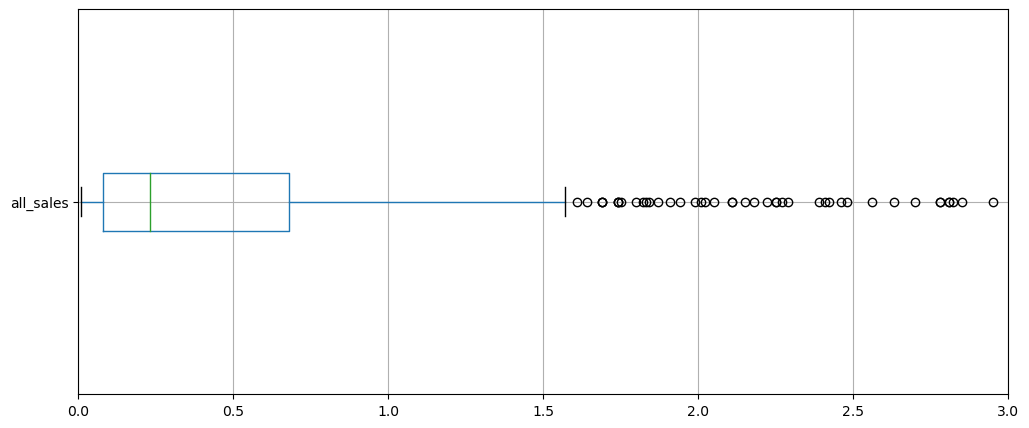

In [96]:
data_relevant[data_relevant['platform'] == 'PS3'].boxplot(column='all_sales', vert=False, figsize=(12,5))
plt.xlim(0, 3)

Продажи PS3 в норме меньше 5 единиц, но отдельные значения могут превышать 20. Нормальный размах - до 2. 

<AxesSubplot:>

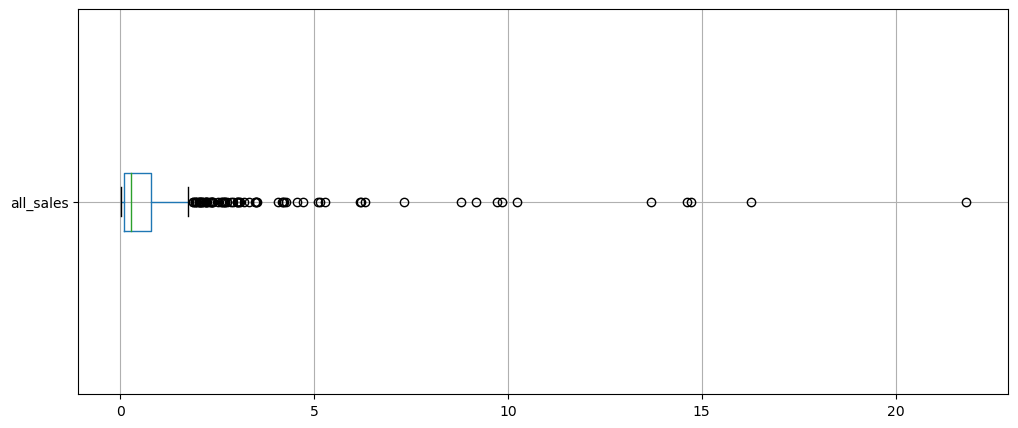

In [39]:
data_relevant[data_relevant['platform'] == 'X360'].boxplot(column='all_sales', vert=False, figsize=(12,5))

(0.0, 3.0)

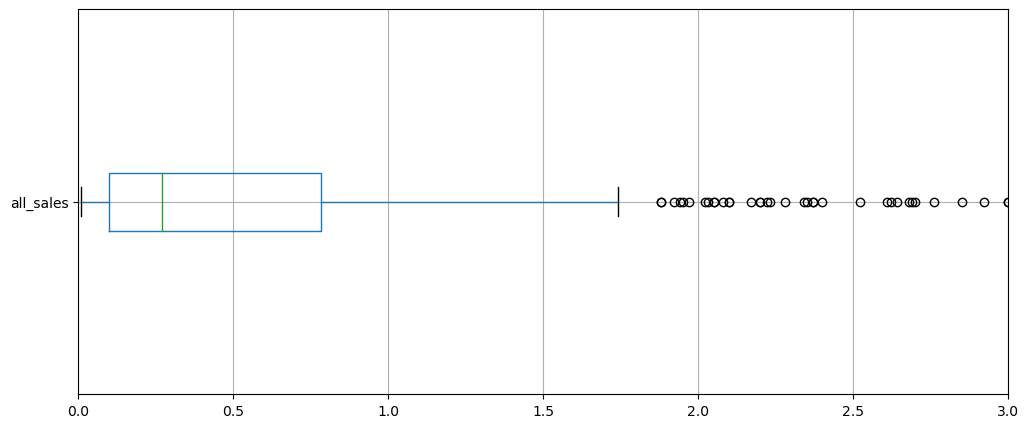

In [97]:
data_relevant[data_relevant['platform'] == 'X360'].boxplot(column='all_sales', vert=False, figsize=(12,5))
plt.xlim(0, 3)

Платформа X360 в норме также не больше 5, но может превышать 20. Нормальный размах - приблизительно до 1.5

<AxesSubplot:>

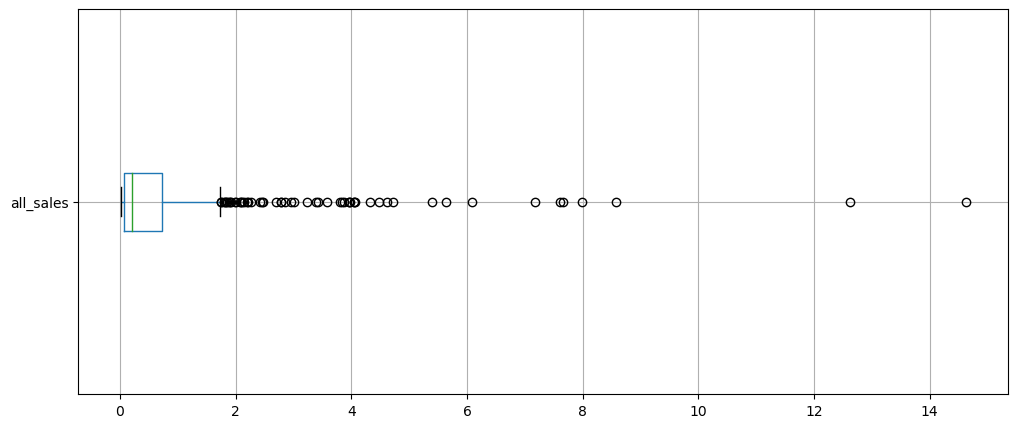

In [40]:
data_relevant[data_relevant['platform'] == 'PS4'].boxplot(column='all_sales', vert=False, figsize=(12,5))

(0.0, 3.0)

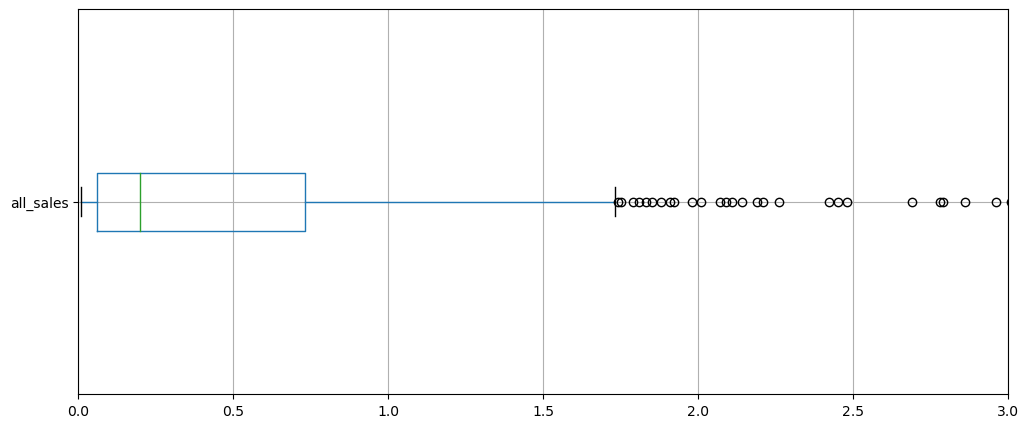

In [98]:
data_relevant[data_relevant['platform'] == 'PS4'].boxplot(column='all_sales', vert=False, figsize=(12,5))
plt.xlim(0, 3)

Средние продажи PS4 до 4 единиц, отдельные значения выше 10. Нормальный размах - до 1.7

<AxesSubplot:>

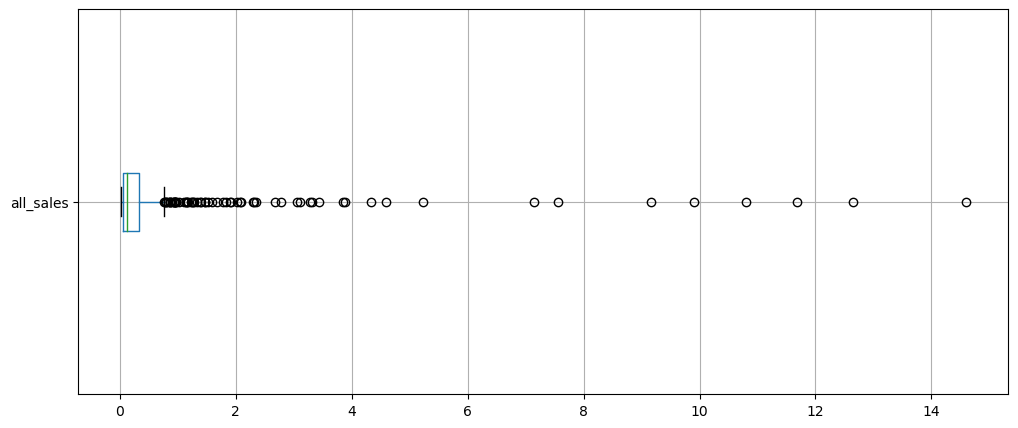

In [41]:
data_relevant[data_relevant['platform'] == '3DS'].boxplot(column='all_sales', vert=False, figsize=(12,5))

(0.0, 3.0)

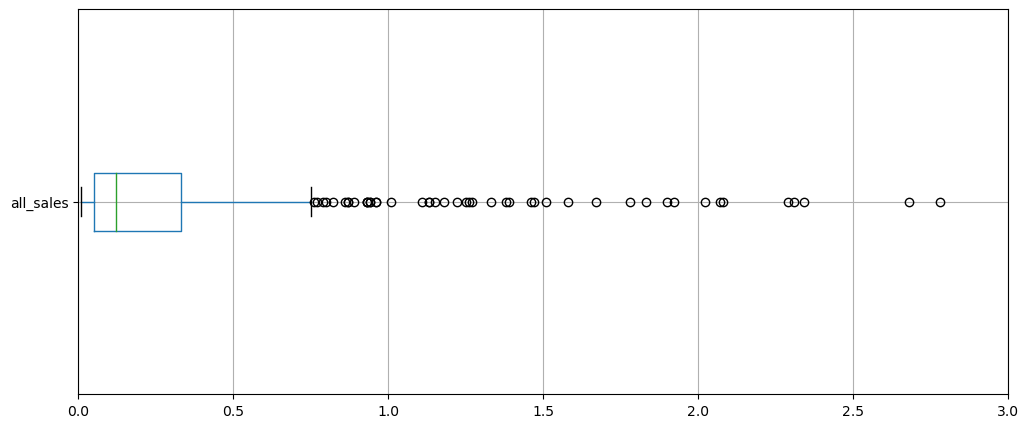

In [99]:
data_relevant[data_relevant['platform'] == '3DS'].boxplot(column='all_sales', vert=False, figsize=(12,5))
plt.xlim(0, 3)

У платформы 3DS в норме продажи доходят до 4, отдельные значения больше 6. Нормальный размах - до 0.7

<AxesSubplot:>

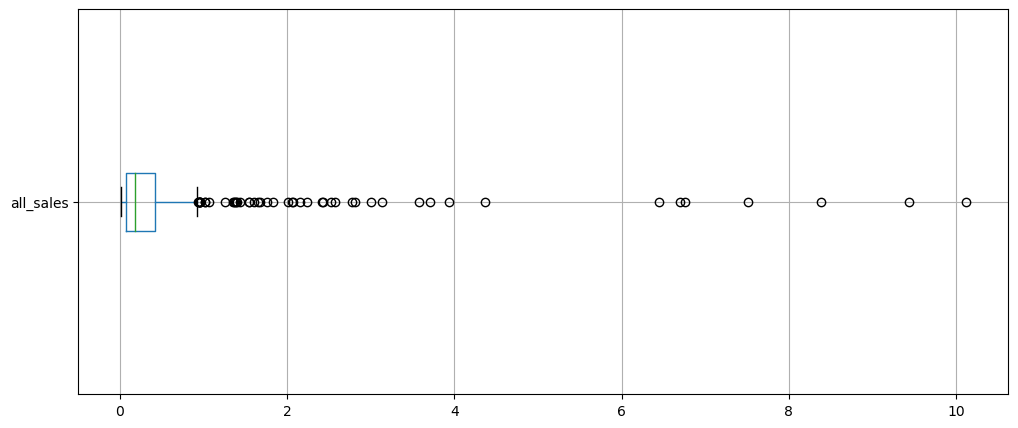

In [42]:
data_relevant[data_relevant['platform'] == 'Wii'].boxplot(column='all_sales', vert=False, figsize=(12,5))

(0.0, 3.0)

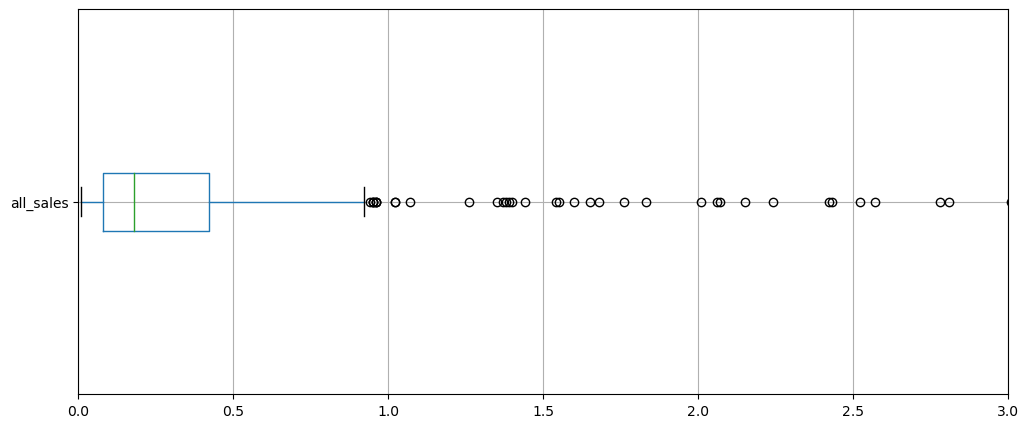

In [100]:
data_relevant[data_relevant['platform'] == 'Wii'].boxplot(column='all_sales', vert=False, figsize=(12,5))
plt.xlim(0, 3)

У Wii продажи в норме до 4, отдельные - больше 4. Нормальный размах чуть меньше 1.

### Оценка влияния на продажи отзывов пользователей и критиков, расчёт корреляции между отзывами и продажами

Необходимо также изучить влияние на продажи отзывов пользователей и критиков: нужно рассмотреть и диаграммы рассеяния, и корреляцию Пирсона. Для изучения возьмём наиболее перспективные платформы: PS4 и 3DS. Они показывают достаточно хорошие показатели продаж. Для удобства работы выделим релевантные данные конкретно об этих платформах в отдельные датафреймы. Также для вычислений необходимо исключить строки, в которых user_score или critic_score закрыт заглушкой undefined из-за пропущенных данных.

In [43]:
ps4 = data_relevant[data_relevant['platform'] == 'PS4']
ps4 = ps4[ps4['user_score'] != 'undefined']
ps4 = ps4[ps4['critic_score'] != 'undefined']
ps4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66


In [44]:
#проверим типы данных в полученном датафрейме
ps4.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
all_sales          float64
dtype: object

In [45]:
ps4['user_score'].corr(ps4['all_sales'])

-0.031957110204556424

<AxesSubplot:xlabel='critic_score', ylabel='all_sales'>

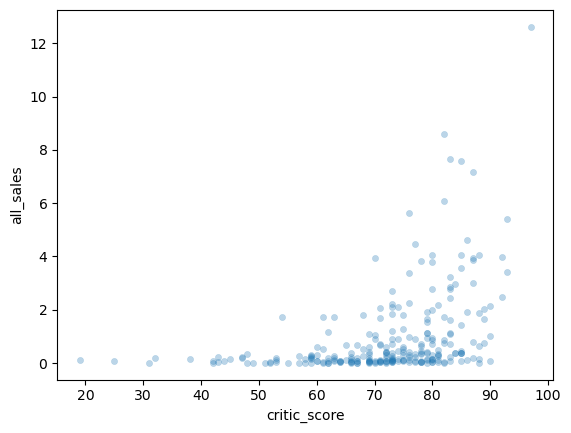

In [46]:
ps4.plot(x='critic_score', y='all_sales', kind='scatter', linewidth= 0.3, alpha = 0.3)

Судя по поэффициенту корреляции Пирсона, оценки от пользователей оказывают небольшое влияние на продажи. Но в среднем на диаграмме рассеяния видно: чем лучше оценки, тем больше продаж. 

In [47]:
ps4['critic_score'].corr(ps4['all_sales'])

0.40656790206178095

<AxesSubplot:xlabel='critic_score', ylabel='all_sales'>

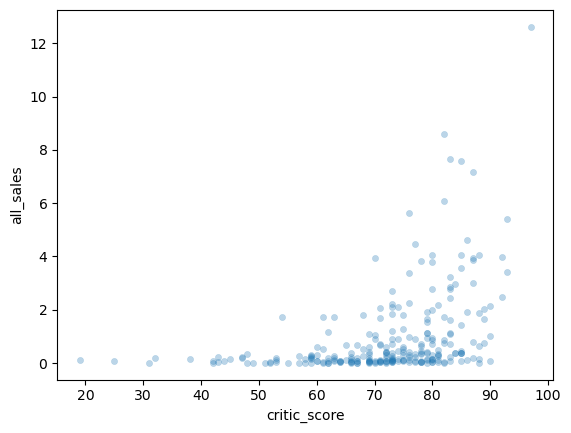

In [48]:
ps4.plot(x='critic_score', y='all_sales', kind='scatter', linewidth= 0.3, alpha = 0.3)

Повторим все действия для 3DS. 

In [49]:
threeds = data_relevant[data_relevant['platform'] == '3DS']
threeds = threeds[threeds['user_score'] != 'undefined']
threeds = threeds[threeds['critic_score'] != 'undefined']
threeds.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
40,Mario Kart 7,3DS,2011,Racing,5.03,4.02,2.69,0.91,85.0,8.2,E,12.65
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
53,Super Mario 3D Land,3DS,2011,Platform,4.89,3.00,2.14,0.78,90.0,8.4,E,10.81
62,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90


In [50]:
#проверим типы данных в полученном датафрейме
threeds.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
all_sales          float64
dtype: object

In [51]:
threeds['user_score'].corr(threeds['all_sales'])

0.22207843643390882

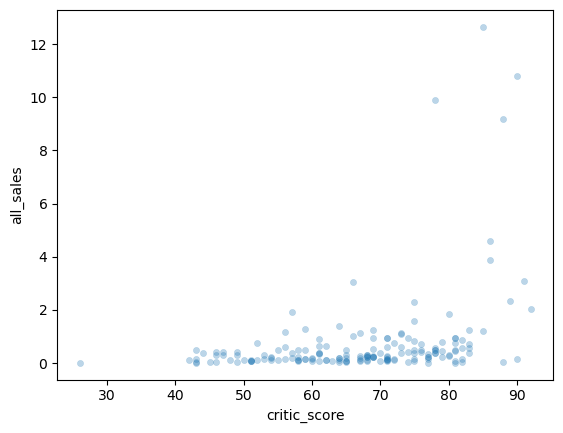

In [52]:
threeds.plot(x='critic_score', y='all_sales', kind='scatter', linewidth= 0.3, alpha = 0.3);

Оценки от игроков оказывают не такое значительное влияние на продажи и в случае с этой платформой.

In [53]:
threeds['critic_score'].corr(threeds['all_sales'])

0.3487397305984834

<AxesSubplot:xlabel='critic_score', ylabel='all_sales'>

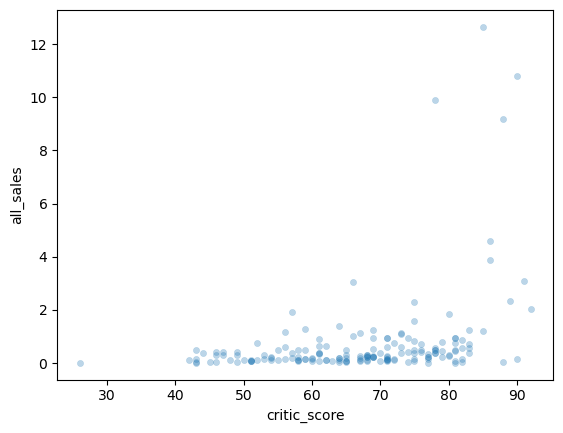

In [54]:
threeds.plot(x='critic_score', y='all_sales', kind='scatter', linewidth= 0.3, alpha = 0.3)

Оценки от критиков оказывают большее влияние на продажи.

И по коэффициенту корреляции Пирсона, и по диаграмме рассеяния видно что оценки от критиков довольно сильно влияют на продажи игры: чем лучше оценки от критиков, тем больше продаж.

### Изучение общего распределения игр по жанрам

Рассмотрим общее распределение продаж игр по жанрам. 

In [55]:
data_relevant.groupby('genre')['all_sales'].median().sort_values(ascending=False)

genre
Shooter         0.385
Platform        0.210
Sports          0.200
Fighting        0.180
Racing          0.170
Role-Playing    0.150
Action          0.140
Misc            0.130
Simulation      0.100
Strategy        0.080
Puzzle          0.070
Adventure       0.030
Name: all_sales, dtype: float64

По медианным значениям наиболее прибыльный жанр игр - shooter, на втором месте platform, на третьем - sports. Самые низкие продажи у strategy, puzzle и adventure.

### Промежуточный вывод 

В ходе исследовательского анализа данных были проанализированы данные за весь период, за период с 2010 по 2016 годы, отдельно для платформ. 
Количество выпускаемых игр с годами значительно возросло. Больше всего игр было выпущено с 2006 по 2011 год.
Наибольшие суммарные продажи за весь период имеют PS2(1233), PS3(931), X360(961), DS(802) и Wii(891).
Средний "срок жизни" платформы - 7-10 лет.
Для дальнейшего анализа был выделен отдельный датафрейм с данными с 2010 по 2016 год для создания прогноза на 2017 год. В релевантной выборке самой популярной игровой платформой была PS3(587),на втором месте X360(550), третье место у PS4(314), четвёртое у 3DS(257), и пятое у Wii(222). 
Наиболее перспективные и растущие платформы, как видно на графиках - PS4 и 3DS. Для всех платформ по боксплотам средние продажи не более 5 миллионов копий игры. 
Также была изучена зависимость между отзывами от игроков и критиков и общими продажами игры. Для изучения были выбраны наиболее перспективные платформы: PS4 и 3DS. Согласно диаграммаv рассеяния и коэффициенту корреляции Пирсона, оценки от игроков не оказывают большого влияния на продажи игры, но в целом видна зависимость между более высокими продажами игры и более высокими оценками от игроков. В то время как оценки от критиков оказывают значительное влияние на продажи: чем лучше оценки критиков, тем выше продажи игры. По медианным значениям наиболее прибыльный жанр игр - shooter, на втором месте platform, на третьем - sports. Самые низкие продажи у strategy, puzzle и adventure.

## Шаг 4. Составление портрета пользователя каждого региона

Изучим общий портрет пользователя из каждого региона: наиболее популярные платормы, жанры и рейтинги от ESBR в регионах. 

### Изучение самых популярных платформ(топ-5) для пользователей каждого региона

Для рассмотрения наиболее популярных платформ для пользователей каждого региона построим отдельные таблицы и графики для каждого из трёх регионов.

In [56]:
data_japan = data.pivot_table(
    index='platform',
    values='jp_sales', 
    aggfunc='sum').sort_values('jp_sales', ascending=False).head()
data_japan

,jp_sales
platform,
DS,175.02
PS,139.78
PS2,137.54
SNES,116.55
3DS,100.62


In [57]:
data_japan_all = data.pivot_table(
    index='platform',
    values='jp_sales', 
    aggfunc='sum').sort_values('jp_sales', ascending=False)

In [58]:
data_japan.loc['Other', 'jp_sales'] = data_japan_all.iloc[5:].sum()[0]

Text(0.5, 1.0, '5 самых популярных платформ в Японии')

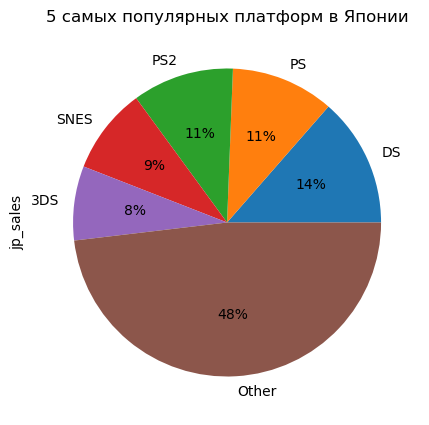

In [59]:
data_japan.plot(kind='pie', y='jp_sales', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('5 самых популярных платформ в Японии')

Пять самых популярных платформ на японском рынке - DS, PD, PS2, SNES и 3DS. 

Как видно на диаграмме, наиболее популярная платформа - DS - 14% от всех игр на рынке, Платформы PS и PS2 имеют одинаковые доли в 11%, SNES и 3DS - 9% и 8% соответственно. 

In [60]:
data_europe = data.pivot_table(
    index='platform',
    values='eu_sales', 
    aggfunc='sum').sort_values('eu_sales', ascending=False).head()
data_europe

,eu_sales
platform,
PS2,332.63
PS3,327.21
X360,268.32
Wii,258.32
PS,212.39


In [61]:
data_europe_all = data.pivot_table(
    index='platform',
    values='eu_sales', 
    aggfunc='sum').sort_values('eu_sales', ascending=False)

In [62]:
data_europe.loc['Other', 'eu_sales'] = data_europe_all.iloc[5:].sum()[0]

Text(0.5, 1.0, '5 самых популярных платформ в Европе')

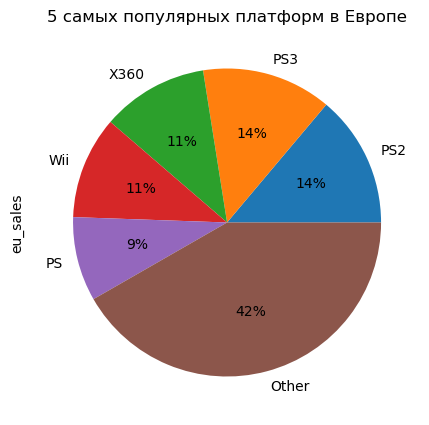

In [63]:
data_europe.plot(kind='pie', y='eu_sales', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('5 самых популярных платформ в Европе')

Cамые популярные платформы в Европе - PS2, PS3, X360, Wii и PS. 

В Европе 14% рынка получает PS2, немногим меньше - 14% - PS3, X360 получает 11%, Wii 11%, а PS - 9% 

In [64]:
data_north_america = data.pivot_table(
    index='platform',
    values='na_sales', 
    aggfunc='sum').sort_values('na_sales', ascending=False).head()
data_north_americadata_europe_all = data.pivot_table(
    index='platform',
    values='eu_sales', 
    aggfunc='sum').sort_values('eu_sales', ascending=False)

data_europe.loc['Other', 'eu_sales'] = data_europe_all.iloc[5:].sum()[0]

In [65]:
data_na_all = data.pivot_table(
    index='platform',
    values='na_sales', 
    aggfunc='sum').sort_values('na_sales', ascending=False)

In [66]:
data_north_america.loc['Other', 'na_sales'] = data_na_all.iloc[5:].sum()[0]

Text(0.5, 1.0, '5 самых популярных платформ в Северной Америке')

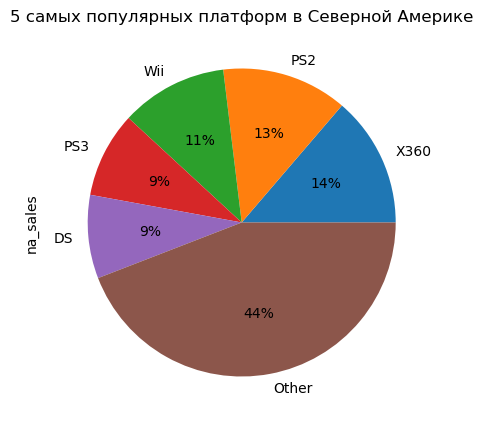

In [67]:
data_north_america.plot(kind='pie', y='na_sales', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('5 самых популярных платформ в Северной Америке')

В Северной Америке популярнее всего платформа X360, на втором месте PS2, на третьем Wii, на четвёртом PS3, и на пятом DS.

Самая популярная платформа - X360, получает 14% от продаж, PS2 - 13%, Wii - 11%, PS3 - 9% и так же 9% - DS.

### Изучение самых популярных жанров(топ-5) для пользователей каждого региона

Изучим также наиболее популярные жанры игр среди различных регионов. 

In [68]:
data_genre_na = data.pivot_table(
    index='genre',
    values='na_sales', 
    aggfunc='sum').sort_values('na_sales', ascending=False).head()
data_genre_na

,na_sales
genre,
Action,863.17
Sports,671.20
Shooter,584.83
Platform,444.44
Misc,399.57


In [69]:
data_genre_na_all = data.pivot_table(
    index='genre',
    values='na_sales', 
    aggfunc='sum').sort_values('na_sales', ascending=False)

In [70]:
data_genre_na.loc['Other', 'na_sales'] = data_genre_na_all.iloc[5:].sum()[0]

Text(0.5, 1.0, '5 самых популярных жанров в Северной Америке')

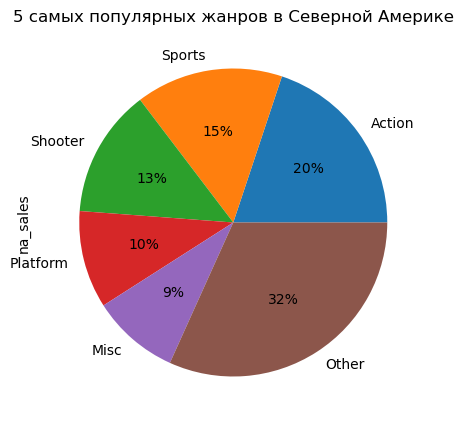

In [71]:
data_genre_na.plot(kind='pie', y='na_sales', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('5 самых популярных жанров в Северной Америке')

В Северной Америке самый популярный жанр игр - action, он занимает 20%, на втором месте - sports с 15%, на третьем - shooter - 13%, на четвёртом - platform - 10% и 9% имеет жанр misc. 

In [72]:
data_genre_japan = data.pivot_table(
    index='genre',
    values='jp_sales', 
    aggfunc='sum').sort_values('jp_sales', ascending=False).head()
data_genre_japan

,jp_sales
genre,
Role-Playing,353.39
Action,160.14
Sports,134.93
Platform,130.71
Misc,107.02


In [73]:
data_genre_japan_all = data.pivot_table(
    index='genre',
    values='jp_sales', 
    aggfunc='sum').sort_values('jp_sales', ascending=False)

In [74]:
data_genre_japan.loc['Other', 'jp_sales'] = data_genre_japan_all.iloc[5:].sum()[0]

Text(0.5, 1.0, '5 самых популярных жанров в Японии')

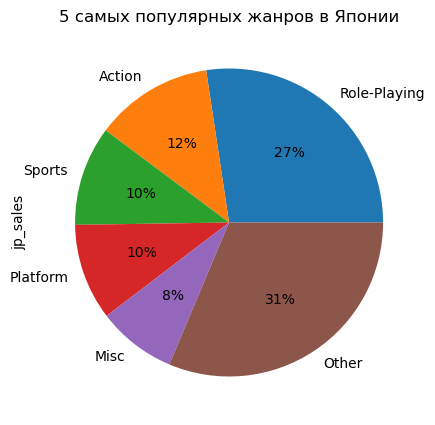

In [75]:
data_genre_japan.plot(kind='pie', y='jp_sales', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('5 самых популярных жанров в Японии')

На японском рынке популярнее всего жанр role-playing - 27%, на втором месте action - 12%, на третьем sports - 10%, четвёртое место получает platform - 10% и напятом месте misc - 8%. 

In [76]:
data_genre_europe = data.pivot_table(
    index='genre',
    values='eu_sales', 
    aggfunc='sum').sort_values('eu_sales', ascending=False).head()
data_genre_europe

,eu_sales
genre,
Action,510.99
Sports,371.33
Shooter,314.52
Racing,234.49
Misc,210.60


In [77]:
data_genre_europe_all = data.pivot_table(
    index='genre',
    values='eu_sales', 
    aggfunc='sum').sort_values('eu_sales', ascending=False)

In [78]:
data_genre_europe.loc['Other', 'eu_sales'] = data_genre_europe_all.iloc[5:].sum()[0]

Text(0.5, 1.0, '5 самых популярных жанров в Европе')

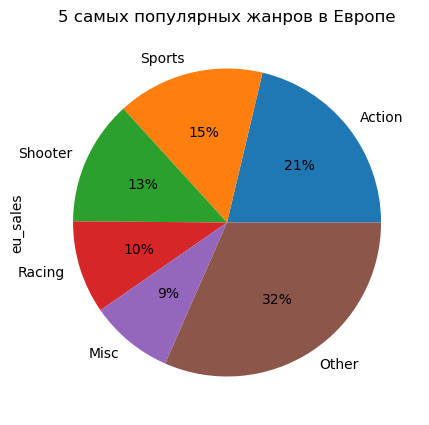

In [79]:
data_genre_europe.plot(kind='pie', y='eu_sales', legend=False, figsize=(12,5), autopct='%.0f%%')
plt.title('5 самых популярных жанров в Европе')

В Европе популярнее всего жанр action - 21%, sports имеет 15%, shooter - 13%, на четвёртом месте racing - 10%, и на пятом misc - 9%.

### Изучение влияния рейтинга ESRB на продажи в отдельном регионе

Также необходимо изучить взаимосвязь рейтинга ESRB на продажи в отдельных регионах. 

In [80]:
data_north_america_esrb = data.pivot_table(
    index='rating',
    values='na_sales', 
    aggfunc='sum').sort_values('na_sales', ascending=False)
data_north_america_esrb

,na_sales
rating,
E,1274.24
NaN,1225.84
T,747.60
M,742.89
E10+,345.50
K-A,2.56
EC,1.53
AO,1.26
RP,0.00


На рынке Северной Америки игры с рейтингом Е имеют больше всего продаж, а игры с рейтингом RP вообще не имеют продаж. 

In [81]:
data_europe_esrb = data.pivot_table(
    index='rating',
    values='eu_sales', 
    aggfunc='sum').sort_values('eu_sales', ascending=False)
data_europe_esrb

,eu_sales
rating,
E,703.87
NaN,609.65
M,480.00
T,421.79
E10+,183.35
AO,0.61
K-A,0.27
EC,0.11
RP,0.03


В Европе популярнее всего игры с возрастным рейтингом E. На последнем месте также рейтинг RP.

In [82]:
data_japan_esrb = data.pivot_table(
    index='rating',
    values='jp_sales', 
    aggfunc='sum').sort_values('jp_sales', ascending=False)
data_japan_esrb

,jp_sales
rating,
NaN,836.74
E,197.96
T,150.70
M,63.58
E10+,40.20
K-A,1.46
AO,0.00
EC,0.00
RP,0.00


В Японии больше всего покупают игры, не получившие рейтинг ESRB, на втором месте игры рейтинга E, а игры с возрастным рейтингом AO, EC и RP не продаются. 

Так, наблюдается явная взаимосвязь: во всех трёх регионах в топе игры с возрастным рейтингом E - for everyone, игры без особенной жестокости и насилия. Это логично, ведь частые пользователи видеоигр - дети. Отсутствие продаж у игр с рейтингом RP также объяснимо: RP - рейтинг "rating pending", чаще всего присваивается играм, которые ещё не были выпущены в продажу. В дальнейшем игры получают рейтинг и поступают в продажу. Также логично, что в Японии  популярнее всего игры без ESRB рейтинга: в Японии возрастными рейтингами занимается CERO, некоммерческая организация. Японский рынок во многом обособлен, и часть игр были созданы для японского рынка и не подавались на европейский рейтинг ESRB. 

### Промежуточный вывод

В ходе исследования были изучены наиболее популярные платформы и жанры игр в отдельных регионах. 
Средний пользователь из Северной Америки любит играть в action игры на своей X360. 
Средний пользователь из Японии предпочитает role-playing игры на платформе DS.
Средний пользователь из Европы играет в action игры на PS2. 
Подтвердилось наличие взаимосвязи между возрастным рейтингом игры и её продажами: так, во всех регионах, кроме японского, популярнее всего рейтинг Е - for everyone, для всех возрастов. Большинство игр, активно продающихся в Японии, не имеют рейтинга ESRB, потому что японский рынок обособлен и игры, созданные для японского рынка, не подавались на присвоение европейского возрастного рейтинга.  

## Шаг 5. Проверка гипотез 

Проверим гипотезы о равенстве средних пользовательских рейтингов платформ и средних пользовательских рейтингов жанров игр. Для этого сформулируем и проверим гипотезы. 

### Одинаковы ли средние пользовательские рейтинги платформ Xbox One и PC?

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные. 

In [83]:
from scipy import stats as st

In [108]:
xone = data.loc[(data['platform'] == 'XOne') & (data['user_score'].isna() == False)]['user_score']
pc = data.loc[(data['platform'] == 'PC') & (data['user_score'].isna() == False)]['user_score']
# results - вызов метода для проверки гипотез
results = st.ttest_ind(xone, pc, equal_var=False)
# alpha - значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue == alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу ')

4.5385802963771835e-06
Не получилось отвергнуть нулевую гипотезу 


Вычисления показали: нулевая гипотеза верна, средние пользовательские рейтинги у платформ Xbox One и PC не отличаются. 

### Отличаются ли средние пользовательские рейтинги жанров Action и Sports? 

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые. 

In [106]:
action = data.loc[(data['genre'] == 'Action') & (data['user_score'].isna() == False)]['user_score']
sports = data.loc[(data['genre'] == 'Sports') & (data['user_score'].isna() == False)]['user_score']
# results - вызов метода для проверки гипотез
results = st.ttest_ind(action, sports, equal_var=False)
# alpha - значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу ')

0.07370217419278526
Не получилось отвергнуть нулевую гипотезу 


Вычисления показали: нулевая гипотеза не верна, средние пользовательские рейтинги у жанров игр action и sports не отличаются. 

## Шаг 6. Общий вывод. 

В этом проекте я исследовала исторические данные о продажах игр, оценках пользователей и критиков, жанры и игровые платформы. Цель исследования - выявить определяющие успешность игры закономерности, чтобы в 2017 году сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

На первом и втором шагах я открыла датафрейм и подготовила данные к исследованию: привела названия столбцов к нижнему регистру, преобразовала данные в нужные типы, обработала пропуски. В некоторых столбцах - user_score, critic_score и rating предположить логичную замену было невозможно, к тому же, в дальнейшем на основе этих данных необходимо провести статистический анализ, и заполнение синтетическими данными исказило бы статистику. Природа пропусков в столбцах с оценками от критиков и игроков, возможно, объясняется небольшой популярностью некоторых игр: они просто не получили достаточно оценок для присвоения рейтинга. В случае с ESRB рейтингом можно предполагать, что не все игры подавались на присвоение этого рейтинга.

На третьем шаге в ходе исследовательского анализа данных были проанализированы данные за весь период, за период с 2010 по 2016 годы, отдельно для платформ. 
Количество выпускаемых игр с годами значительно возросло. Больше всего игр было выпущено с 2006 по 2011 год. Наибольшие суммарные продажи за весь период имеют PS2(1233), PS3(931), X360(961), DS(802) и Wii(891). Средний "срок жизни" платформы - 7-10 лет. Для дальнейшего анализа был выделен отдельный датафрейм с данными с 2010 по 2016 год для создания прогноза на 2017 год. В релевантной выборке самой популярной игровой платформой была PS3(587),на втором месте X360(550), третье место у PS4(314), четвёртое у 3DS(257), и пятое у Wii(222). Наиболее перспективные и растущие платформы, как видно на графиках - PS4 и 3DS. Для всех платформ по боксплотам средние продажи не более 5 миллионов копий игры. Также была изучена зависимость между отзывами от игроков и критиков и общими продажами игры. Для изучения были выбраны наиболее перспективные платформы: PS4 и 3DS. Согласно диаграммаv рассеяния и коэффициенту корреляции Пирсона, оценки от игроков не оказывают большого влияния на продажи игры, но в целом видна зависимость между более высокими продажами игры и более высокими оценками от игроков. В то время как оценки от критиков оказывают значительное влияние на продажи: чем лучше оценки критиков, тем выше продажи игры. По медианным значениям наиболее прибыльный жанр игр - shooter, на втором месте platform, на третьем - sports. Самые низкие продажи у strategy, puzzle и adventure.

На четвёртом шаге был составлен портрет пользователя каждого региона. 
В ходе исследования были изучены наиболее популярные платформы и жанры игр в отдельных регионах. Средний пользователь из Северной Америки любит играть в action игры на своей X360. Средний пользователь из Японии предпочитает role-playing игры на платформе DS. Средний пользователь из Европы играет в action игры на PS2. Подтвердилось наличие взаимосвязи между возрастным рейтингом игры и её продажами: так, во всех регионах, кроме японского, популярнее всего рейтинг Е - for everyone, для всех возрастов. Большинство игр, активно продающихся в Японии, не имеют рейтинга ESRB, потому что японский рынок обособлен и игры, созданные для японского рынка, не подавались на присвоение европейского возрастного рейтинга.

На пятом шаге были проверены две гипотезы: "Средние пользовательские рейтинги платформ Xbox one и PC одинаковые" и "Средние пользовательские рейтинги жанров Action и Sports разные. Вычисления показали: первая нулевая гипотеза верна, средние пользовательские рейтинги у платформ Xbox One и PC не отличаются. Вторая гипотеза была отвергнута: средние пользовательские рейтинги игр жанров Action и Sports не отличаются. 